<a href="https://colab.research.google.com/github/sharonwu827/Deep-Learning/blob/master/Automated_Essay_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approach

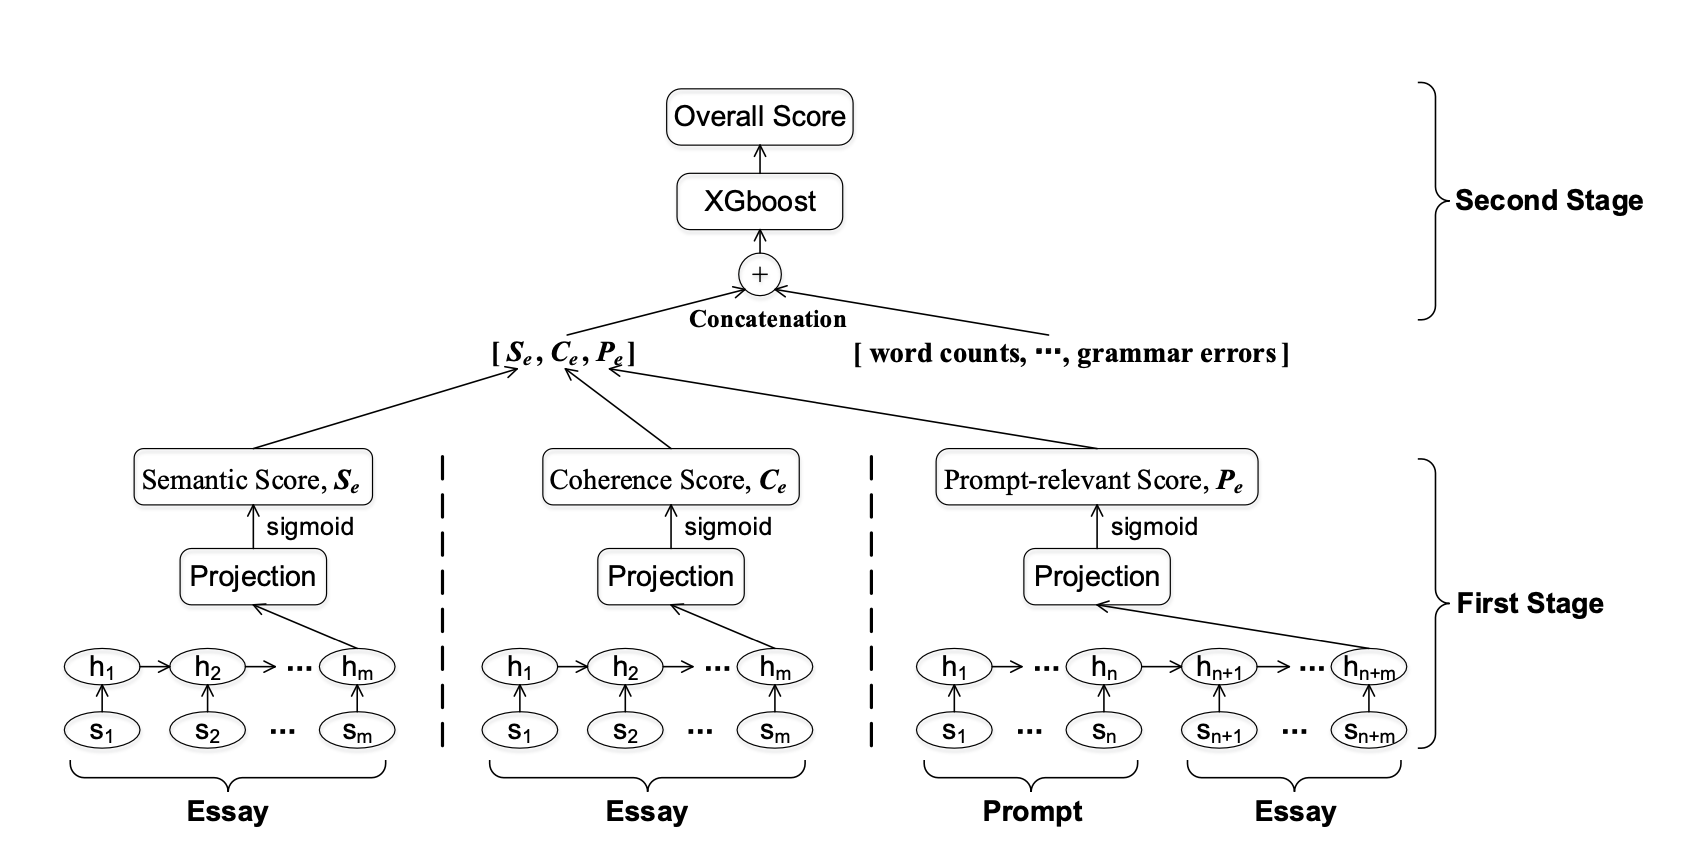


**Two-Stage Learning Framework**

Two-Stage Learning Framework (TSLF), which combines the advantages of feature-engineered models and end-to-end models. 


- In the first stage, based on deep neural networks, we calculate semantic score, coherence score and prompt-relevant score, named as Se, Ce and Pe respectively. Ce and Pe are proposed to detect adversarial samples. 

- In the second stage, we concatenate these three scores with some handcrafted features and feed the result to the boosting tree model for further training.






## Algorithm

- Convolutional Neural Network 
- Recurrent Neural Network



## Evaluation Metric

The output of an AES system can be compared to the ratings assigned by human annotators using various measures of correlation or agreement (Yannakoudakis and Cummins, 2015). These measures include 
- Pearson’s correlation
- Spearman’s correlation
- Kendall’s Tau
- **quadratic weighted Kappa (QWK)**




# 1. Data Overview

There are **eight different essay** sets which have texts ranging from 100 to 600 words. They each consist of around 1500 samples. These sets are divided according to the level of the student and the differences in their tasks. Some of them are dependent on a certain topic whereas others are general writing. They are written by students from 7th grade to 10th grade and in a score range of 0-6. 

Each of files contains 28 columns:

- essay_id: A unique identifier for each individual student essay (`could be dropped`)
- essay_set: 1-8, an id for each set of essays
- essay: The ascii text of a student's response
- rater1_domain1: Rater 1's domain 1 score; all essays have this
- rater2_domain1: Rater 2's domain 1 score; all essays have this
- rater3_domain1: Rater 3's domain 1 score; only some essays in set 8 have this. (`could be dropped`)
- **domain1_score: Resolved score between the raters; all essays have this**
- rater1_domain2: Rater 1's domain 2 score; only essays in set 2 have this (`could be dropped`)
- rater2_domain2: Rater 2's domain 2 score; only essays in set 2 have this (`could be dropped`)
- domain2_score: Resolved score between the raters; only essays in set 2 have this (`could be dropped`)
- rater1_trait1 score - rater3_trait6 score: trait scores for sets 7-8 (`could be dropped`)


In [ ]:
# import packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk  #The Natural Language Toolkit
import tensorflow as tf
!pip install transformers
import torch
# BERT and T5 are easily imported from Hugging Face's transformer library (https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel
from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration

     |████████████████████████████████| 2.5MB 32.2MB/s 
     |████████████████████████████████| 901kB 34.3MB/s 
     |████████████████████████████████| 3.3MB 27.2MB/s 


In [32]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/asap-aes/training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1')
dev = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/asap-aes/valid_set.tsv",sep='\t', encoding='ISO-8859-1')
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/asap-aes/test_set.tsv",sep='\t', encoding='ISO-8859-1')

In [33]:
# Create a dataframe for adding prompt of each essay set to get the prompt-relevant score
prompt = pd.DataFrame({"essay_set":[1,2,3,4,5,6,7,8],
                       "prompt":["More and more people use computers, but not everyone agrees that this benefits society. Those who support advances in technology believe that computers have a positive effect on people. They teach hand-eye coordination, give people the ability to learn about faraway places and people, and even allow people to talk online with other people. Others have different ideas. Some experts are concerned that people are spending too much time on their computers and less time exercising, enjoying nature, and interacting with family and friends. Write a letter to your local newspaper in which you state your opinion on the effects computers have on people. Persuade the readers to agree with you.",
                                "Write a persuasive essay to a newspaper reflecting your vies on censorship in libraries. Do you believe that certain materials, such as books, music, movies, magazines, etc., should be removed from the shelves if they are found offensive? Support your position with convincing arguments from your own experience, observations, and/or reading.",
                                "Write a response that explains how the features of the setting affect the cyclist. In your response, include examples from the essay that support your conclusion.",
                                "Write a response that explains why the author concludes the story with this paragraph. In your response, include details and examples from the story that support your ideas.",
                                "Describe the mood created by the author in the memoir. Support your answer with relevant and specific information from the memoir.",
                                "Based on the excerpt, describe the obstacles the builders of the Empire State Building faced in attempting to allow dirigibles to dock there. Support your answer with relevant and specific information from the excerpt.",
                                "Write about patience. Being patient means that you are understanding and tolerant. A patient person experience difficulties without complaining.Do only one of the following: write a story about a time when you were patient OR write a story about a time when someone you know was patient OR write a story in your own way about patience.",
                                "We all understand the benefits of laughter. For example, someone once said, “Laughter is the shortest distance between two people.” Many other people believe that laughter is an important part of any relationship. Tell a true story in which laughter was one element or part."]})
prompt

,essay_set,prompt
0,1,"More and more people use computers, but not ev..."
1,2,Write a persuasive essay to a newspaper reflec...
2,3,Write a response that explains how the feature...
3,4,Write a response that explains why the author ...
4,5,Describe the mood created by the author in the...
5,6,"Based on the excerpt, describe the obstacles t..."
6,7,Write about patience. Being patient means that...
7,8,We all understand the benefits of laughter. Fo...


In [34]:
train=train[['essay_set','essay','rater1_domain1','rater2_domain1','domain1_score']]
train.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


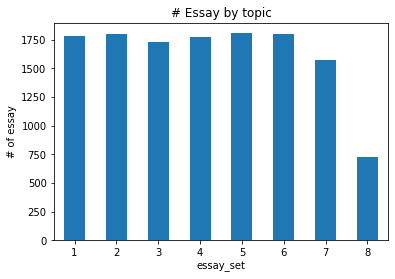

In [35]:
train.groupby('essay_set').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('# Essay by topic')
plt.ylabel('# of essay')
plt.show()

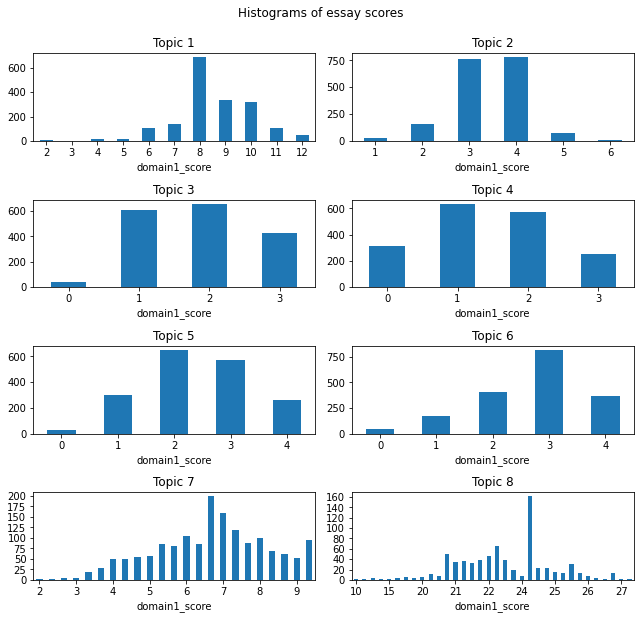

In [36]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        train[train['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_set']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [37]:
# Normalization the domain1_score
train['normalized_score'] = train['domain1_score'] / train.groupby('essay_set')['domain1_score'].transform('max')
train.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,normalized_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8,0.666667
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,0.750000
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,0.583333
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,0.833333
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,0.666667


## Pre processing

personally identifying information from the essays are anonymizated, and the relevant entities are identified and replaced with a string such as "@PERSON1."

The entitities identified by NER are: "PERSON", "ORGANIZATION", "LOCATION", "DATE", "TIME", "MONEY", "PERCENT"

as maximum sequence size for BERT is 512, so we’ll remove those anoymaization.

In [38]:
def clean_anonymization(essay):
  res=[]
  for i in essay.split():
    if i.startswith("@"):
      continue
    else:
      res.append(i)
  return ' '.join(res)

train['essay']=train['essay'].apply(lambda x:clean_anonymization(x))

In [39]:
train['essay'][1]

"Dear I believe that using computers will benefit us in many ways like talking and becoming friends will others through websites like facebook and mysace. Using computers can help us find coordibates, locations, and able ourselfs to millions of information. Also computers will benefit us by helping with jobs as in planning a house plan and typing a page report for one of our jobs in less than writing it. Now lets go into the wonder world of technology. Using a computer will help us in life by talking or making friends on line. Many people have myspace, facebooks, aim, these all benefit us by having conversations with one another. Many people believe computers are bad but how can you make friends if you can never talk to them? I am very fortunate for having a computer that can help with not only school work but my social life and how I make friends. Computers help us with finding our locations, coordibates and millions of information online. If we didn't go on the internet a lot we woul

## BERT 


We need to define the tokenizer. BERT has its own and that is the one that should be used. As it is specific to the (pre-trained) model, we need to specify it. For obvious reasons we will use the 'cased' model.

In [40]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example of the tokenizer, the tokenizer occasionally splits one word into multiple tokens. Because the approach of using word pieces reduces the vocabulary size and/or number of unknown words.

In [41]:
tokenizer.tokenize("Dear I believe that using computers ")

['Dear', 'I', 'believe', 'that', 'using', 'computers']

In [42]:
tokenizer.encode("Dear I believe that using computers")

[101, 12956, 146, 2059, 1115, 1606, 7565, 102]

In [43]:
# A [CLS] token is inserted at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
tokenizer.convert_tokens_to_ids(["CLS","Dear", "I", "believe", "that", "using", "computers","[SEP]"])

[100, 12956, 146, 2059, 1115, 1606, 7565, 102]

In [44]:
tokenizer.convert_ids_to_tokens([101])

['[CLS]']

In [45]:
# defining a BERT model that is created from one of the pre-trained models
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.layers

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Next, let us look at the weights in 'the' main layer. There are actually many layers in BERT. It starts with its own embeddings and goes through various other layers (discussed in detail in next week's live sessions):

In [46]:
len(bert.layers[0].weights)

199

In [58]:
# Tokenization
tokenized = train["essay"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
train['tokenized'] = tokenized 

In [62]:
train.head(3)

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,normalized_score,tokenized
0,1,"Dear local newspaper, I think effects computer...",4,4,8,0.666667,"[101, 12956, 1469, 3054, 117, 146, 1341, 3154,..."
1,1,Dear I believe that using computers will benef...,5,4,9,0.750000,"[101, 12956, 146, 2059, 1115, 1606, 7565, 1209..."
2,1,"Dear, More and more people use computers, but ...",4,3,7,0.583333,"[101, 12956, 117, 3046, 1105, 1167, 1234, 1329..."


### Padding

All the neural networks require to have inputs that have the same shape and size. since every sentence in the text has not the same number of words, we can define maximum number of words for each sentence, if a sentence is longer then we can drop some words.

In [77]:
max_len = 0
for i in train['tokenized']:
    if len(i) > max_len:
        max_len = len(i)

#pad using 0s
train['padded_tokenized'] = np.array([i + ["pad"]*(max_len-len(i)) for i in train['tokenized']]).tolist()
print (f"The length of padded sequence: {max_len}")

The length of padded sequence: 1256


### Masking

Now that all samples have a uniform length, the model must be informed that some part of the data is actually padding and should be ignored. That mechanism is masking.

In [79]:
attention_mask = np.where(train['padded_tokenized'] != "pad")
attention_mask

(array([    0,     1,     2, ..., 12973, 12974, 12975]),)

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
  last_hidden_states = model(input_ids, attention_mask=attention_mask)

## Prompt-relevant Score 

For a specific prompt composed of n sentences p = {s1,s2,··· ,sn} and an essay e = {s1,s2,··· ,sm} with m sentences, we first combine p and e.

In [ ]:
train.head()

In [ ]:
train1=train.merge(prompt,on='essay_set',how='left')
# concat essay with prompt
essay_prompt = []
for i in train1["essay"]:
    for j in train1["prompt"]:
        essay_prompt.append([i,j])

In [ ]:
essay_prompt[1]

In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten,Bidirectional
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True,recurrent_dropout=0.4), input_shape=(1,50), merge_mode='concat'))
    #model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [ ]:
train1.head()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
X = train1[['essay_set','essay','prompt']]
y = train1[['domain1_score']]
cv = KFold(n_splits=5, shuffle=True)
results = []
y_pred_list = []
cv_data =cv.split(X)
count = 1
print(cv_data)